In [12]:
# ------------------------------------------------------------------
# 0. Imports and Setup
# ------------------------------------------------------------------
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

try:
    import chainconsumer, seaborn, emcee, arviz
except:
    print('Installing Non-Default Packages...')
    os.system('pip install seaborn')
    os.system('pip install emcee')
    os.system('pip install chainconsumer')
    os.system('pip install arviz')

# It's good practice to manage your python path this way
# Create a 'scat_analysis' directory for your code if you haven't already
# and place this notebook outside of it.
# e.g., /path/to/project/notebook.ipynb
#       /path/to/project/scat_analysis/__init__.py
#       /path/to/project/scat_analysis/burstfit_pipeline.py
#       ...
# This makes imports clean and explicit.
# If your project root is not in the path, uncomment the following line:
# sys.path.insert(0, '/path/to/your/project/root')

# Use ipython magic for interactive development
%load_ext autoreload
%autoreload 2

# --- Core Pipeline Import ---
from scat_analysis.burstfit_pipeline import BurstPipeline

# --- Interactive Post-processing Imports ---
# These are for optional, interactive analysis after the main run.
from scat_analysis.burstfit_corner import (
    quick_chain_check,
    get_clean_samples,
    make_beautiful_corner,
    make_beautiful_corner_wide
)
from scat_analysis.burstfit import FRBParams

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# ------------------------------------------------------------------
# 1. Configuration
# ------------------------------------------------------------------
# --- Locate data file ---
burst_name = "freya" # Name of the burst to analyze
data_dir = Path("/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/data/chime")
#Path("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/CHIME_bursts/dmphase")
data_dir_parent = data_dir.parent
plot_dir = Path("/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scattering/plots")
#Path("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scattering/plots")

# Use pathlib for robust path handling
try:
    data_path = next(data_dir.glob(f"*{burst_name}*.npy"))
    print(f"Found data file: {data_path}")
except StopIteration:
    raise FileNotFoundError(f"No .npy file containing '{burst_name}' found in {data_dir}")

# --- Set Telescope and Run Parameters ---
# These parameters will be passed directly to the pipeline
pipeline_config = {
    "telescope": "chime",
    "telcfg_path": "configs/telescopes.yaml",
    "sampcfg_path": "configs/sampler.yaml",
    "steps": 1000,          # Total MCMC steps for the final run
    "f_factor": 8,        # Downsampling factor in frequency
    "t_factor": 512,          # Downsampling factor in time
    "center_burst": True,
    "outer_trim": 0.2,
    "smooth_ms": 0.1,
    "nproc": 16,             # Number of processes for multiprocessing
    "yes": True,            # Auto-confirm pool creation
}

Found data file: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/data/chime/freya_chime_I_912_4067_32000b_cntr_bpc.npy


In [24]:
# --- Set Initial Dispersion Measure ---
dm_initial = 0.0 # pc cm^-3

# ------------------------------------------------------------------
# 2. Build and Run the Pipeline
# ------------------------------------------------------------------
# The pipeline is instantiated with all configuration parameters.
# The `with` statement ensures the multiprocessing pool is handled correctly.
pipe = BurstPipeline(
    name=burst_name,
    inpath=data_path,
    outpath=plot_dir,
    dm_init=dm_initial,
    **pipeline_config
)


[BurstFit] running with nproc=16


[INFO | burstfit.pipeline] Finding initial guess for MCMC...
[INFO | burstfit.pipeline] Refined initial guess found via optimization.
[INFO | burstfit.pipeline] Starting model selection scan (BIC)...
100%|██████████| 500/500 [00:02<00:00, 213.84it/s]
[INFO | burstfit.pipeline] Processing MCMC chains...
[INFO | burstfit.pipeline] Auto-determined burn-in: 170, thinning: 19
[INFO | burstfit.pipeline] Running all post-fit diagnostics...


[Model M3]  logL_max = -117917.8 | BIC =  235877.9

→ Best model by BIC: M3


100%|██████████| 250/250 [00:00<00:00, 278.28it/s]
[INFO | burstfit.pipeline] Diagnostics complete.
[INFO | burstfit.pipeline] Best model: M3 | χ²/dof = 49.85
[INFO | burstfit.pipeline] Generating 16-panel comprehensive diagnostics plot...


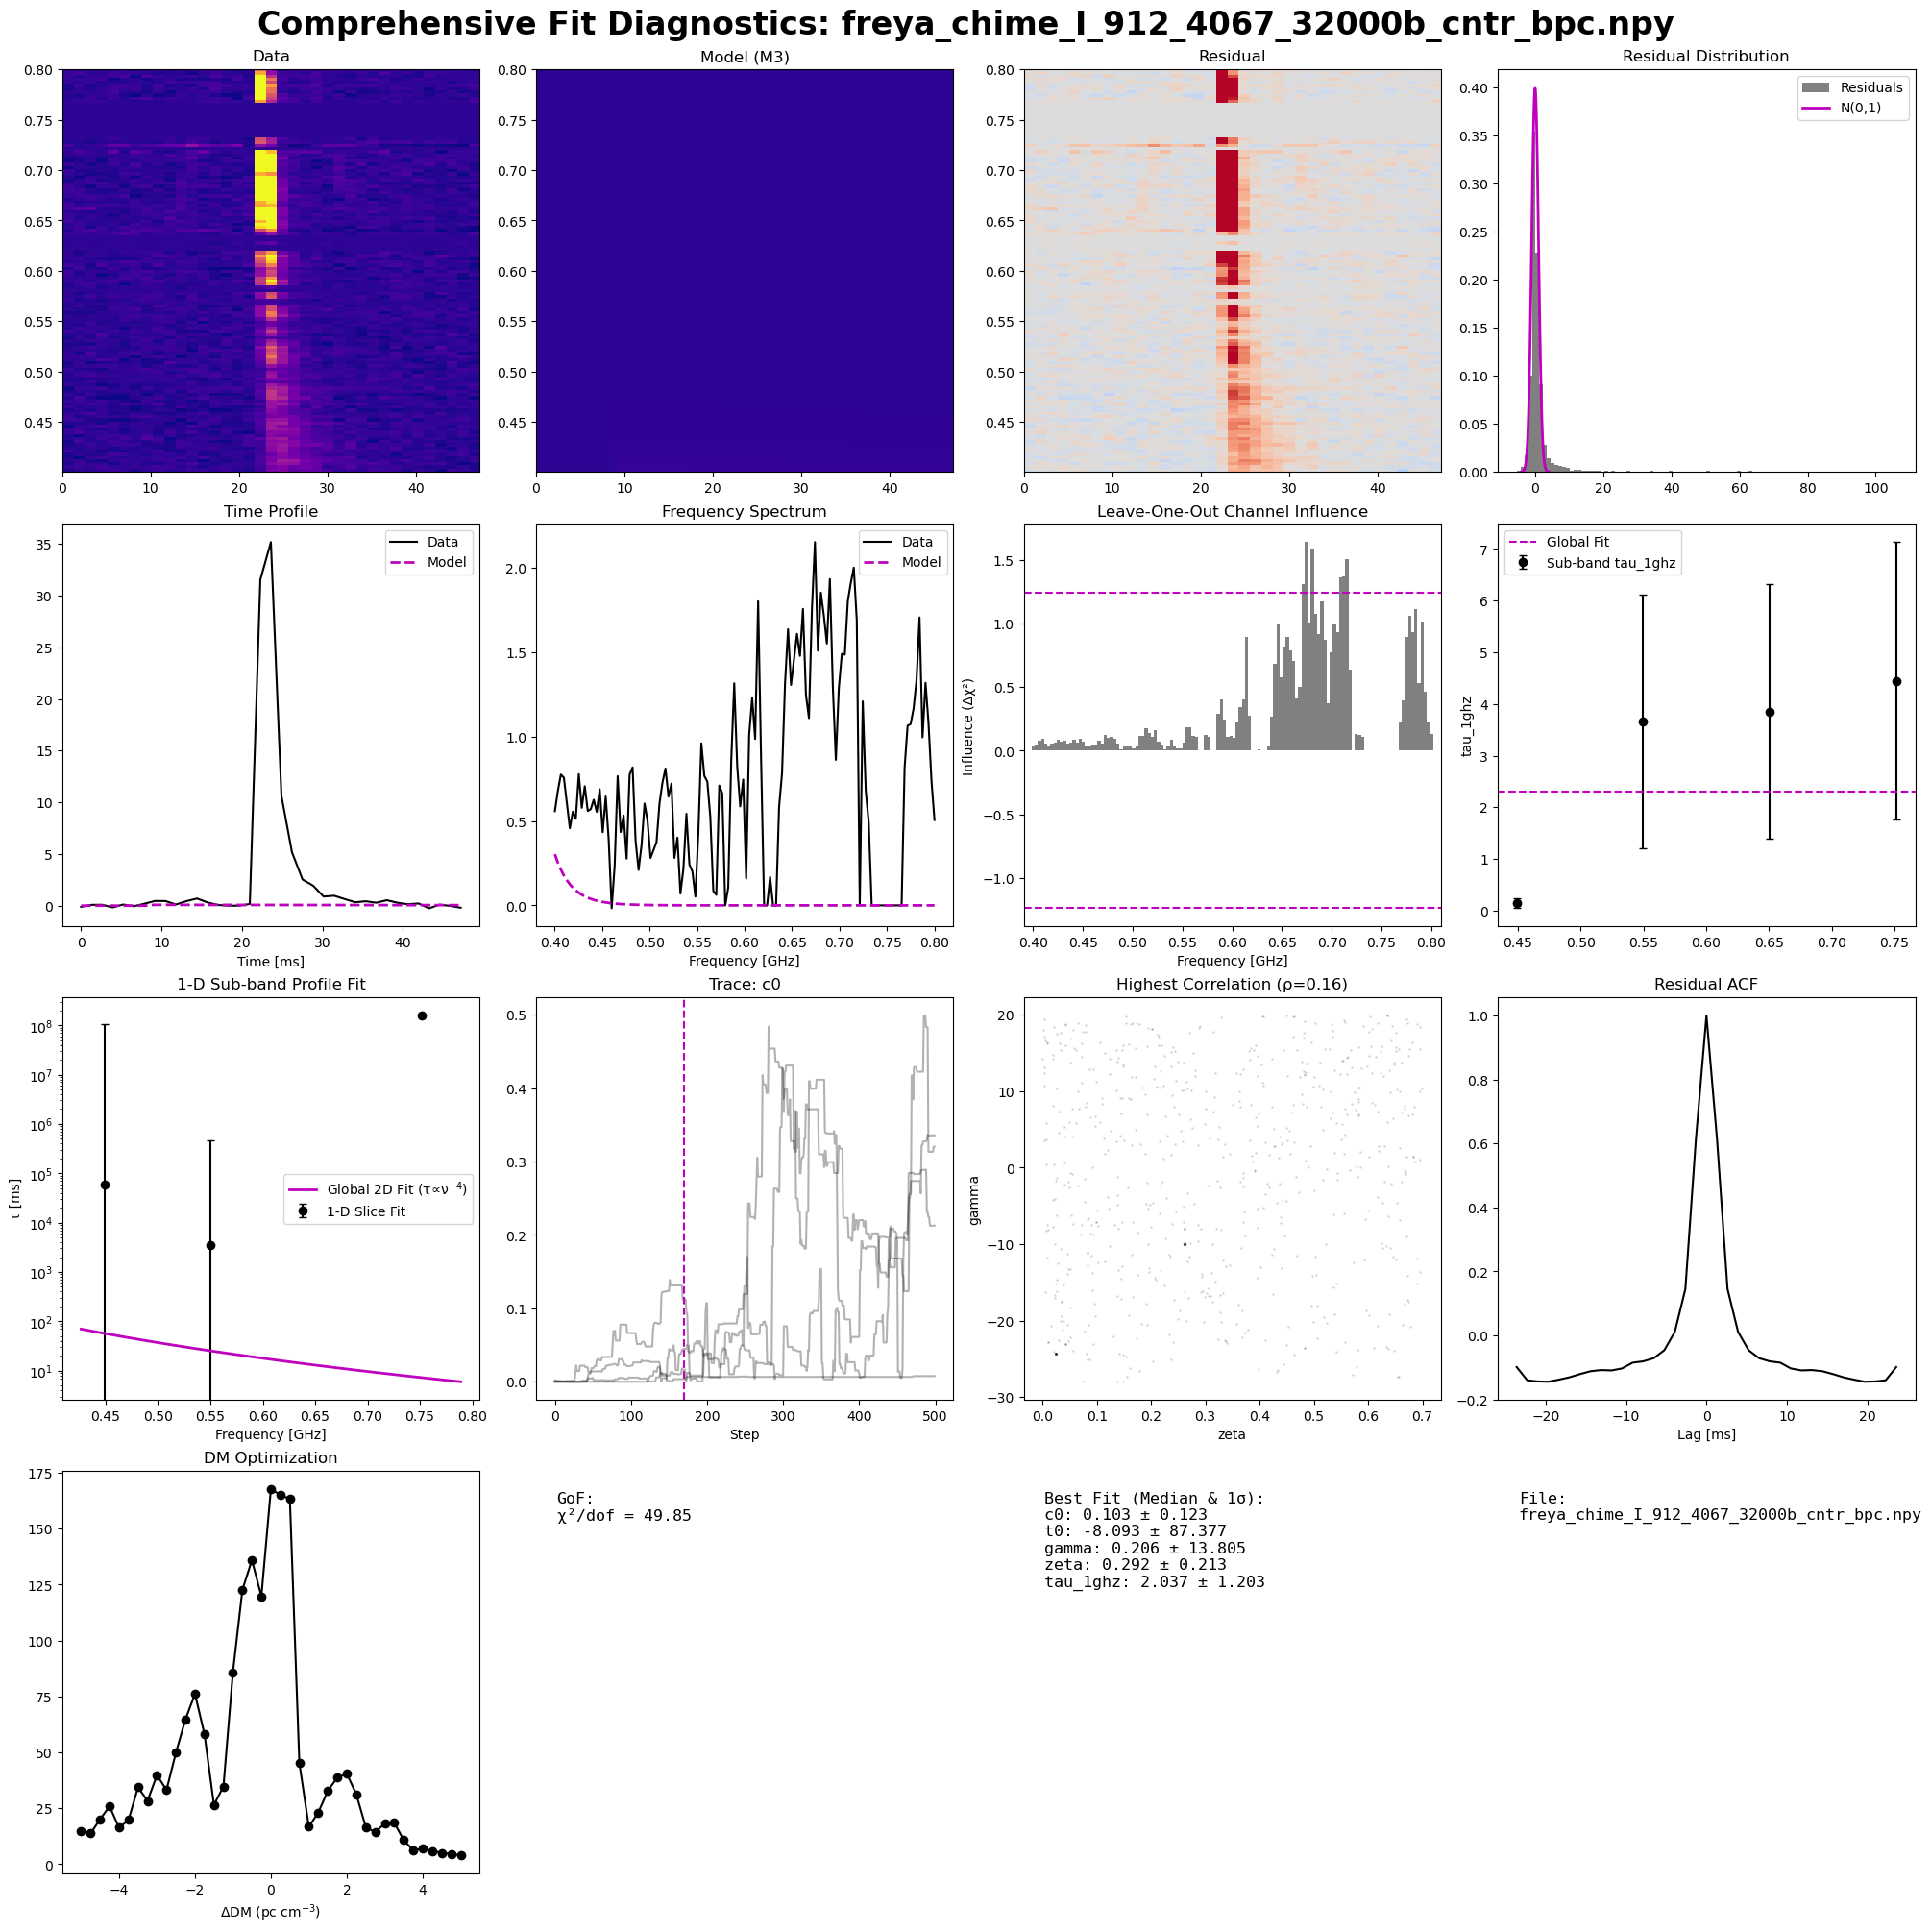

[INFO | burstfit.pipeline] Generating four-panel diagnostic plot...
[INFO | burstfit.pipeline] Saving 4-panel plot to /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scattering/plots/FRB_four_panel.pdf


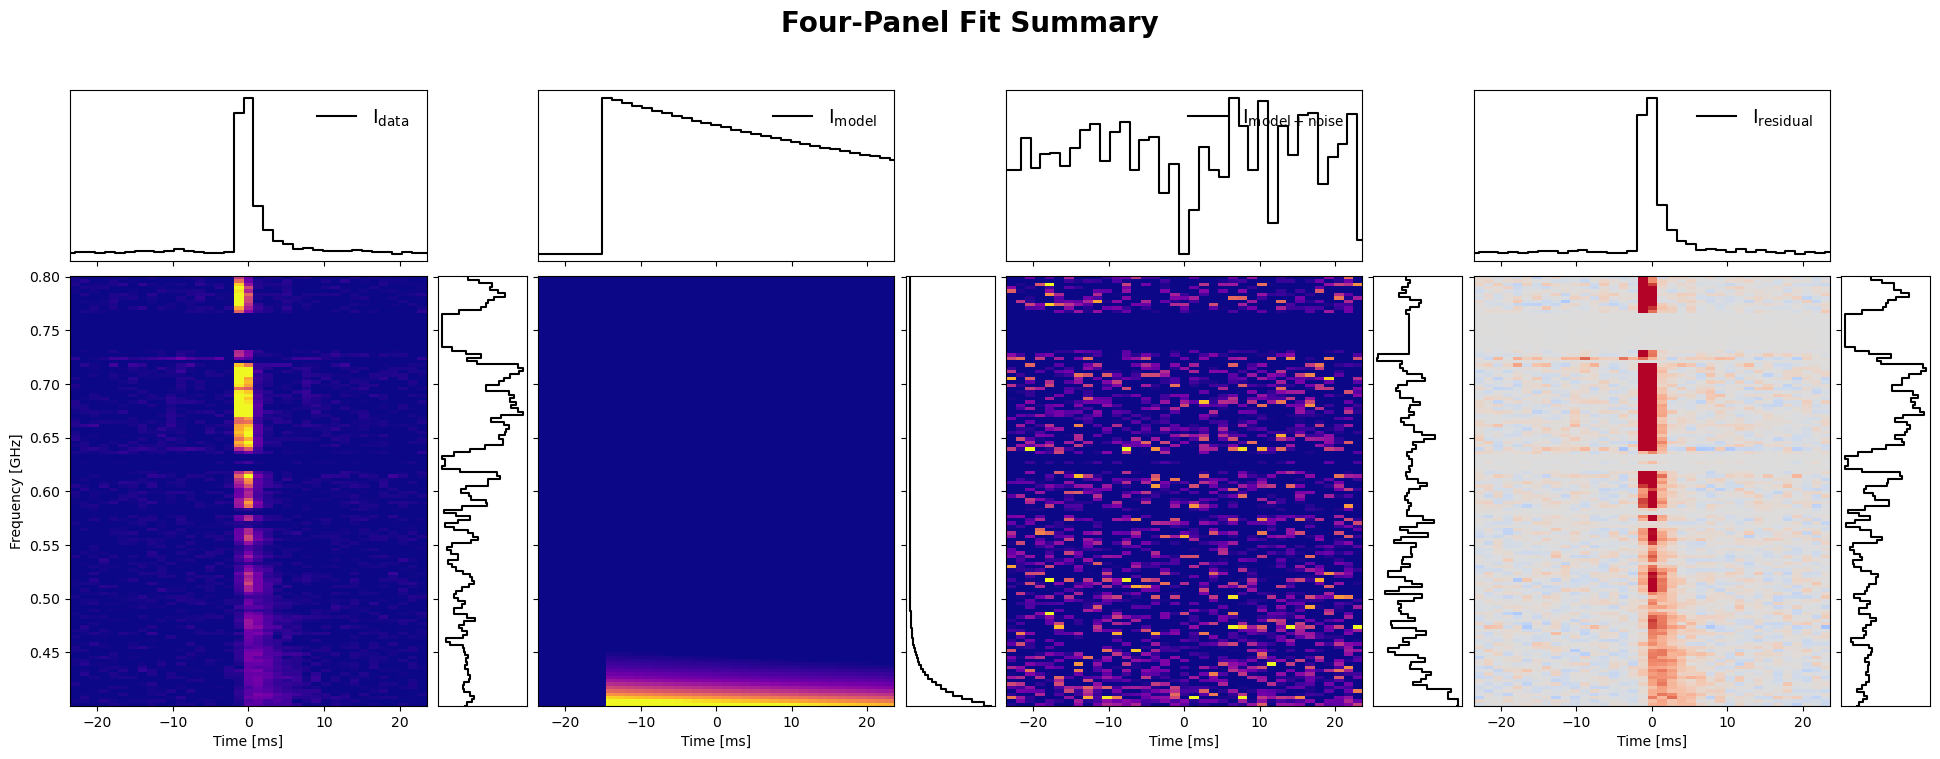

In [25]:
# This single call now performs all the steps:
# - Data loading and preprocessing
# - Finding an optimized initial guess
# - Running the model selection scan (or a direct fit)
# - Processing the MCMC chains
# - Running all diagnostics (sub-band, influence, etc.)
# - Calculating goodness-of-fit
# - Generating and saving the 16-panel summary plot
results = pipe.run_full(
    model_scan=True,      # Perform BIC scan over models M0-M3
    model_keys=["M3"],
    diagnostics=True,     # Run all post-fit diagnostic checks
    plot=True,            # Generate and save the summary plot
    save=True,            # Save output figures
    show=True            # Do not block execution with plt.show()
    
)


In [17]:
# The main results are in the returned dictionary. Let's look at them.
print("\n--- Pipeline Run Summary ---")
print(f"Best model found: {results['best_key']}")
print(f"Reduced Chi-squared: {results['goodness_of_fit']['chi2_reduced']:.2f}")
print("Best-fit parameters (from highest-likelihood sample):")
print(results['best_params'])



# ------------------------------------------------------------------
# 3. Interactive Post-Fit Analysis (Optional)
# ------------------------------------------------------------------
# The main pipeline has already produced a full analysis. The following
# steps are useful for interactively assessing convergence and creating
# custom plots like a detailed corner plot.

sampler = results["sampler"]
best_p = results["best_params"]
param_names = results["param_names"]

# --- FIX: Detach the sampler from the now-closed pool ---
# By setting the pool to None, subsequent calls will run in serial mode.
sampler.pool = None 

# --- Interactively extend the chain until convergence ---
print("\n--- Interactive Chain Convergence Check ---")
max_extra_chunks, chunk_size = 2, 1000 
chunks_added = 0
while not quick_chain_check(sampler):
    if chunks_added >= max_extra_chunks:
        print(f"Reached max extra steps ({max_extra_chunks * chunk_size}); proceeding.")
        break
    print(f"\nChain not fully converged. Running for {chunk_size} more steps...")
    # This call will now work correctly
    sampler.run_mcmc(None, chunk_size, progress=True)
    chunks_added += 1

# --- Generate a high-quality corner plot with the final chain ---
print("\n--- Generating Final Corner Plot ---")
final_clean_samples = get_clean_samples(sampler, param_names, verbose=True)

#fig_corner = make_beautiful_corner(
#    final_clean_samples,
#    param_names,
#    best_params=best_p,
#    title=f"Posterior for {results['best_key']} ({final_clean_samples.shape[0]} samples)"
#)
#
## Save and display the final corner plot
#corner_path = data_path.with_name(f"{data_path.stem}_corner.pdf")
#fig_corner.savefig(corner_path, dpi=200, bbox_inches="tight")
#print(f"Saved corner plot to: {corner_path}")
#plt.show()
#
#fig_corner = make_beautiful_corner_wide(
#    final_clean_samples,
#    param_names,
#    best_params=best_p,
#    title=f"Posterior for {results['best_key']} ({final_clean_samples.shape[0]} samples)"
#)

# Save and display the final corner plot
#corner_path = data_path.with_name(f"{plot_dir}/{burst_name}_scat_corner.pdf")
#fig_corner.savefig(corner_path)
#print(f"Saved corner plot to: {corner_path}")
#plt.show()

# The 4-panel plot is now generated automatically by the pipeline's
# `create_sixteen_panel_plot` or `create_four_panel_plot` functions,
# so the manual plotting code from the old notebook is no longer needed here.

print("\nAnalysis complete.")



--- Pipeline Run Summary ---
Best model found: M3
Reduced Chi-squared: 471.33
Best-fit parameters (from highest-likelihood sample):
FRBParams(c0=np.float64(0.33022607973731516), t0=np.float64(19.67258928350221), gamma=np.float64(9.819455916297466), zeta=np.float64(0.3981034471520539), tau_1ghz=np.float64(3.5153239671439263))

--- Interactive Chain Convergence Check ---
Chain Health Check:
  Log-prob stability: 0.02 (want < 1.0)
  Parameter drift: 2.67 (want < 0.1)
  ⚠️  Chains may need more steps!
  Consider running: sampler.run_mcmc(None, 1000, progress=True)

Chain not fully converged. Running for 1000 more steps...


100%|██████████| 1000/1000 [00:04<00:00, 234.73it/s]


Chain Health Check:
  Log-prob stability: 0.01 (want < 1.0)
  Parameter drift: 2.81 (want < 0.1)
  ⚠️  Chains may need more steps!
  Consider running: sampler.run_mcmc(None, 1000, progress=True)

Chain not fully converged. Running for 1000 more steps...


100%|██████████| 1000/1000 [00:04<00:00, 235.33it/s]
[WARNING | emcee.autocorr] The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 90;
tau: [166.01331715 366.77088599 177.38355024 207.9285202  200.77117346]


Chain Health Check:
  Log-prob stability: 0.02 (want < 1.0)
  Parameter drift: 3.54 (want < 0.1)
  ⚠️  Chains may need more steps!
  Consider running: sampler.run_mcmc(None, 1000, progress=True)
Reached max extra steps (2000); proceeding.

--- Generating Final Corner Plot ---
Detected burn-in: 112 steps
Using thinning: 20
Final samples: 8760 (from 180000 total)
Removed 8625 outlier samples

Analysis complete.



Parameter Summary (median [16%, 84%]):
c0: 0.565 [0.161, 0.886]
t0: -2.641 [-7.995, 21.887]
gamma: -3.242 [-10.592, 6.424]
zeta: 0.459 [0.310, 0.632]
tau_1ghz: 2.270 [0.953, 3.653]
Saved corner plot to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scattering/plots/freya_scat_corner.pdf


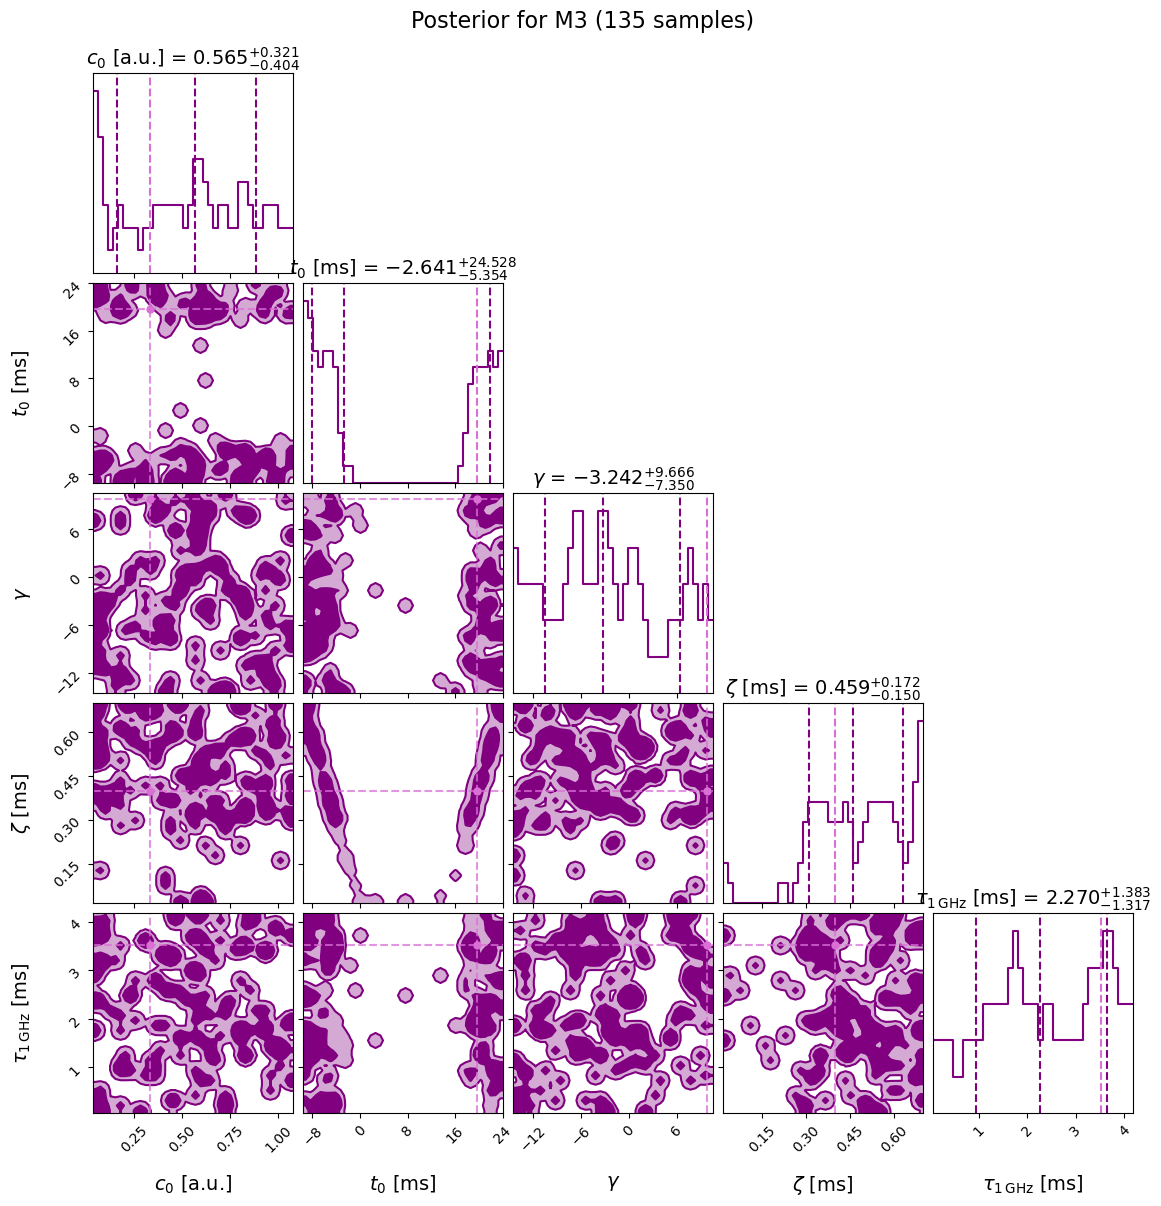


Analysis complete.


In [18]:
fig_corner = make_beautiful_corner(
    final_clean_samples,
    param_names,
    best_params=best_p,
    title=f"Posterior for {results['best_key']} ({final_clean_samples.shape[0]} samples)"
)

# Save and display the final corner plot
corner_path = os.path.join(f"{plot_dir}/{burst_name}_scat_corner.pdf")
fig_corner.savefig(corner_path)
print(f"Saved corner plot to: {corner_path}")
plt.show()

# The 4-panel plot is now generated automatically by the pipeline's
# `create_sixteen_panel_plot` or `create_four_panel_plot` functions,
# so the manual plotting code from the old notebook is no longer needed here.

print("\nAnalysis complete.")